In [1]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.plotting import *
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from decode_fish.engine.microscope import Microscope
from decode_fish.engine.model import UnetDecodeNoBn
import shutil
from torch.utils.tensorboard import SummaryWriter
from decode_fish.engine.point_process import PointProcessUniform
from decode_fish.engine.gmm_loss import PointProcessGaussian

from decode_fish.funcs.visualization import *
import ipyvolume as ipv

base_path =  '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/'

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [3]:
files = glob.glob(base_path + 'datasets/CodFish/smFISH_data_Titlow/*.tif')

In [4]:
def load_tiff_image(image_path: str):
    "Given tiff stack path, loads the stack and converts it to a tensor. If necessary adds a dimension for the batch size"
    image_path = Path(image_path)
    image  = torch.tensor(tiff_imread(image_path).astype('float32'))
    print(image.shape)
    if len(image.shape) == 3: image.unsqueeze_(0)
#     assert len(image.shape) == 4, 'the shape of image must be 4, (1, Z, X, Y)'
    #removing minum values of the image
    return image

/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/smFISH_data_Titlow/Dlg1_smFISH_1.tif
torch.Size([84, 512, 512])


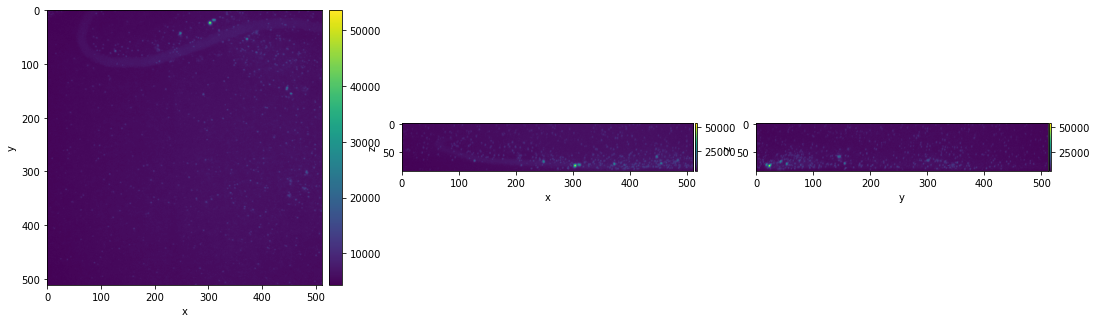

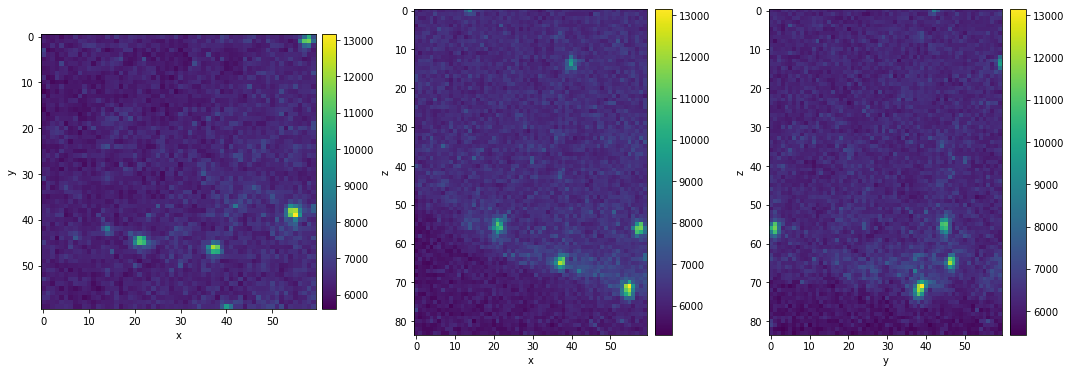

/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/smFISH_data_Titlow/Dlg1_smFISH_2.tif
torch.Size([37, 512, 512])


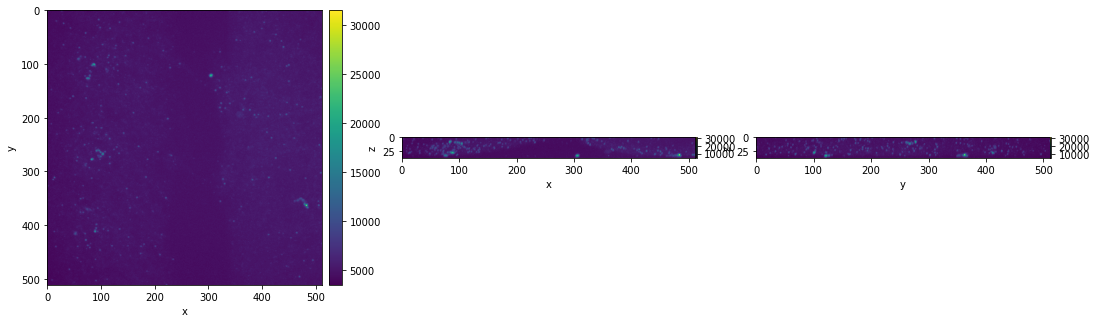

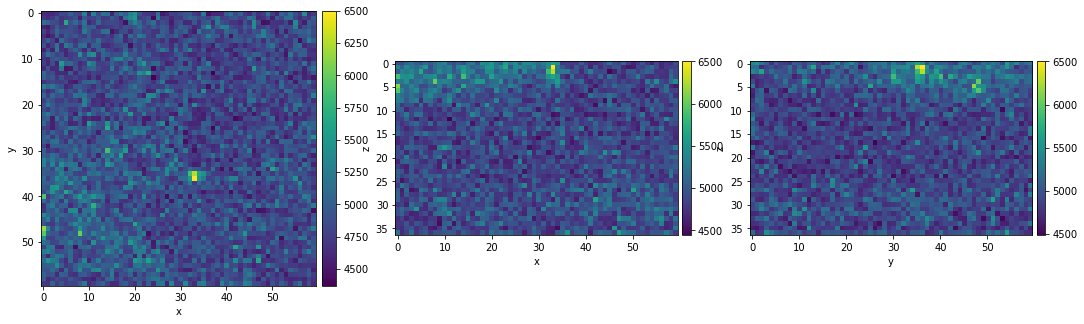

/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/smFISH_data_Titlow/Dlg1_smFISH_3.tif
torch.Size([36, 512, 512])


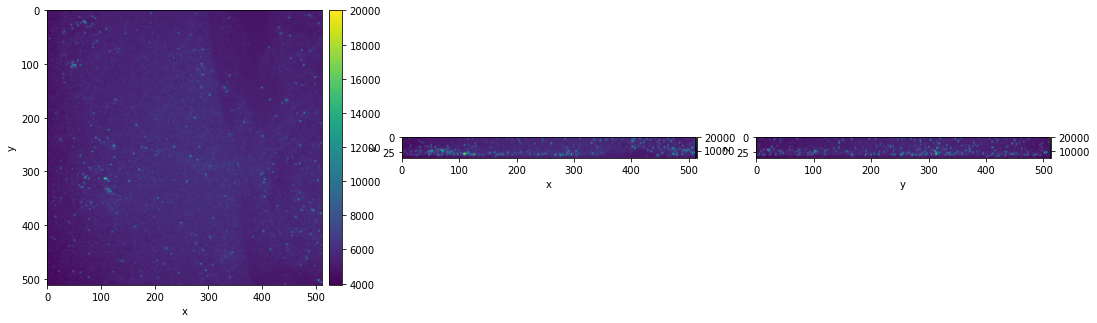

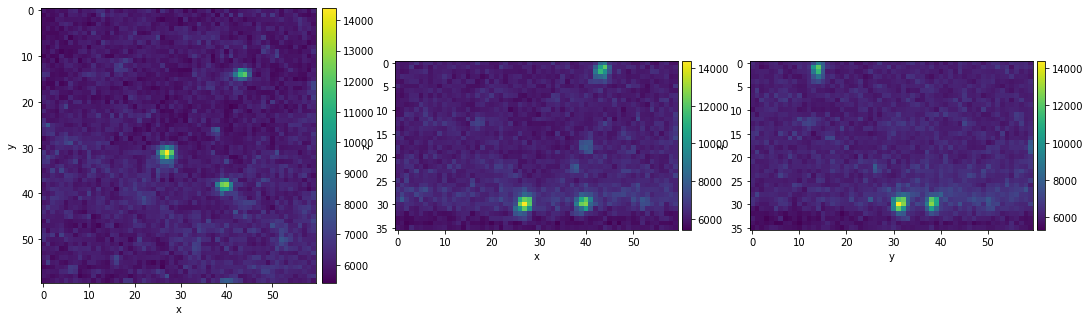

/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/smFISH_data_Titlow/Dlg1_smFISH_4.tif
torch.Size([32, 512, 512])


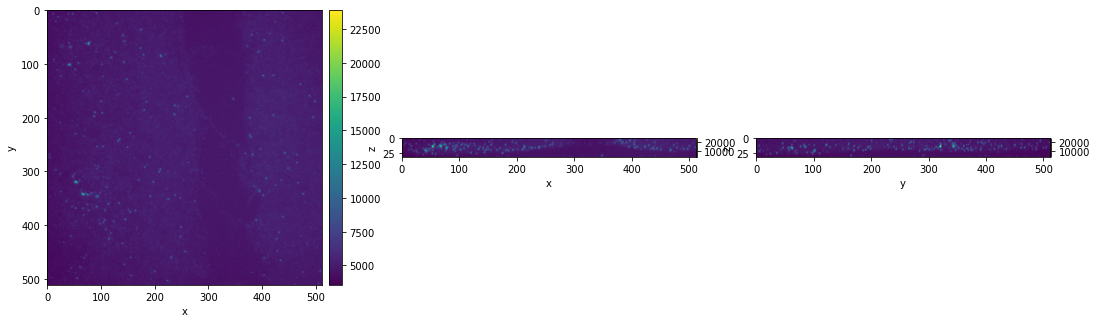

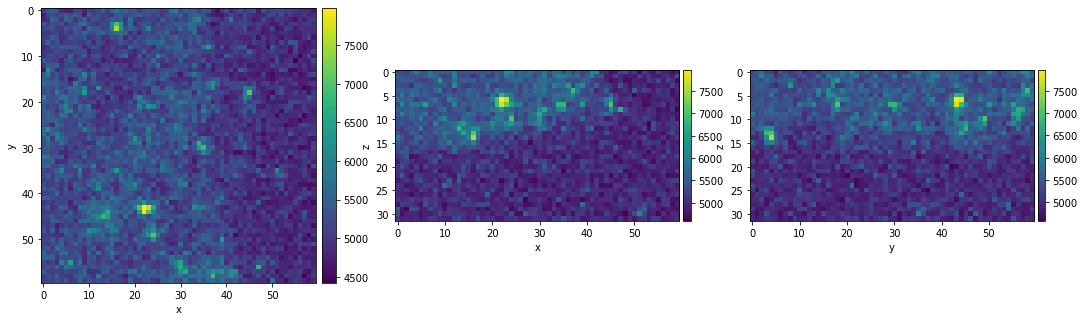

/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/smFISH_data_Titlow/msp300_smFISH_1.tif
torch.Size([37, 512, 512])


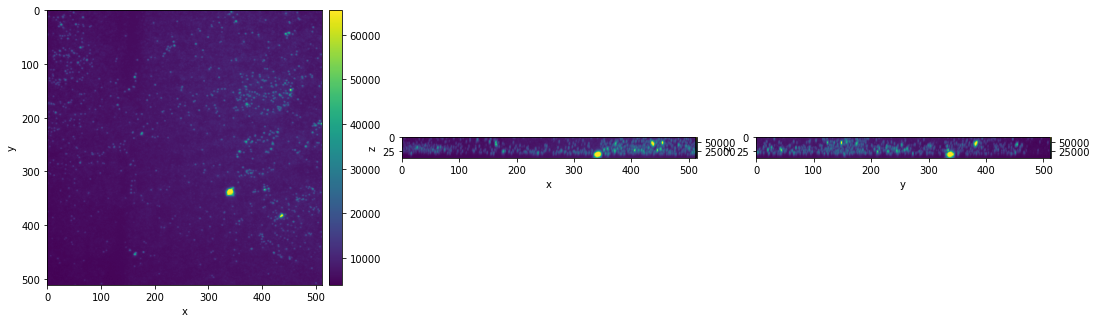

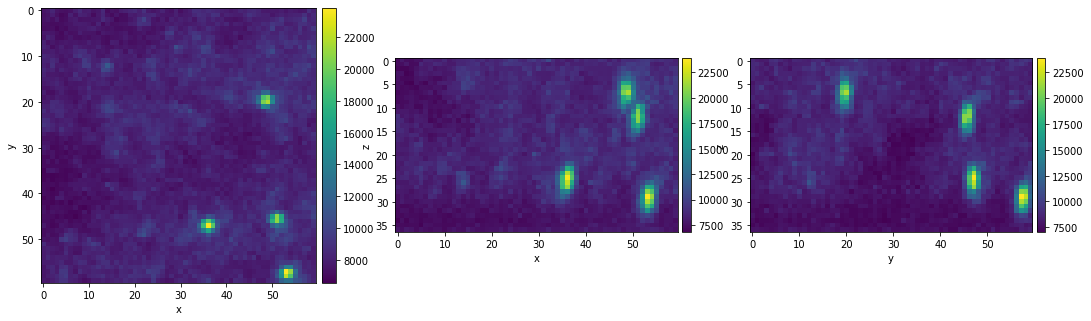

/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/smFISH_data_Titlow/msp300_smFISH_2.tif
torch.Size([28, 512, 512])


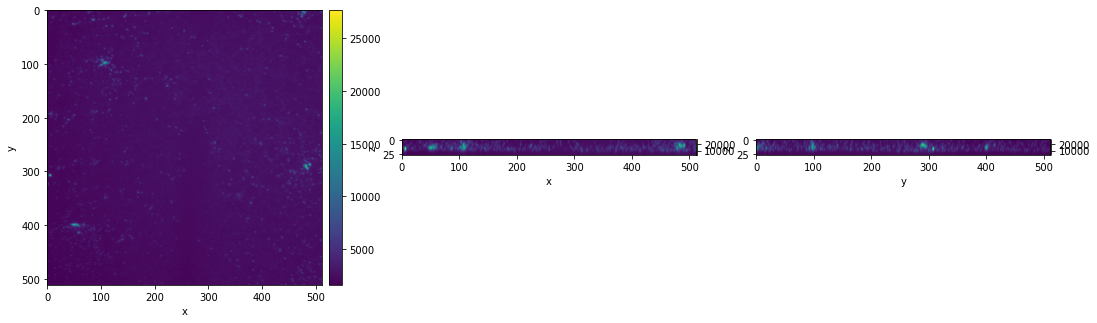

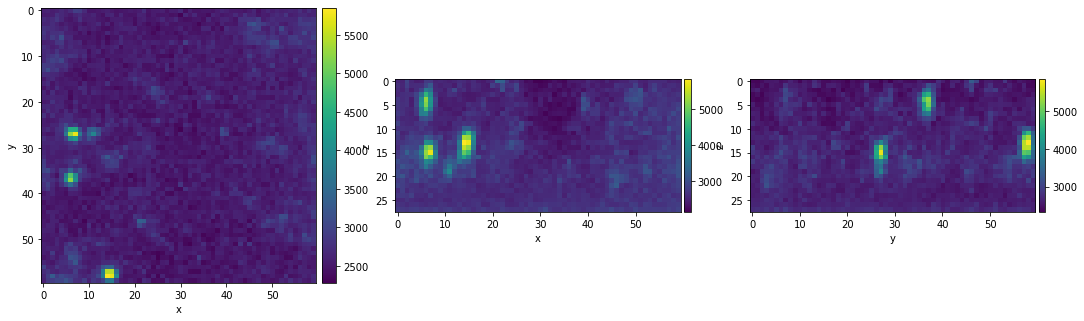

/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/smFISH_data_Titlow/msp300_smFISH_3.tif
torch.Size([37, 512, 512])


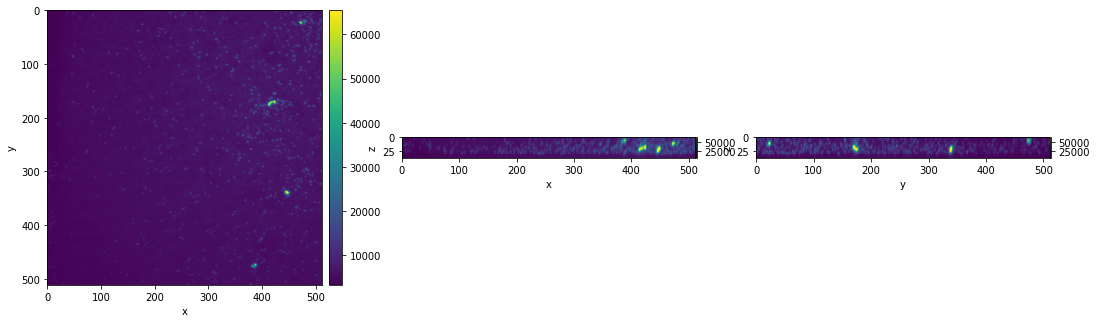

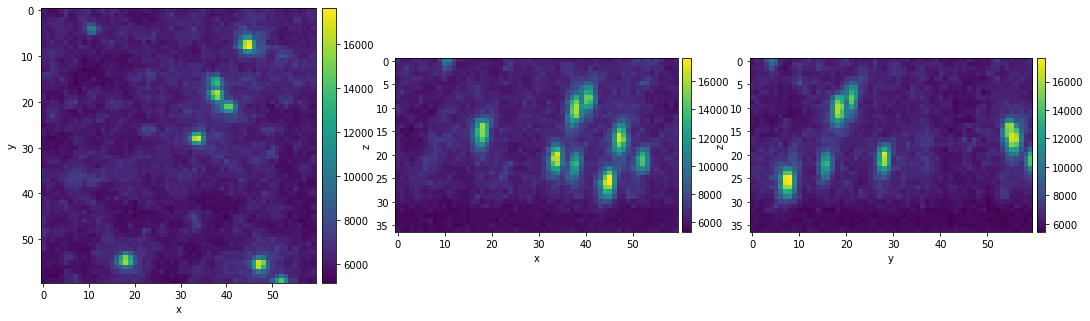

/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/smFISH_data_Titlow/msp300_smFISH_4.tif
torch.Size([37, 512, 512])


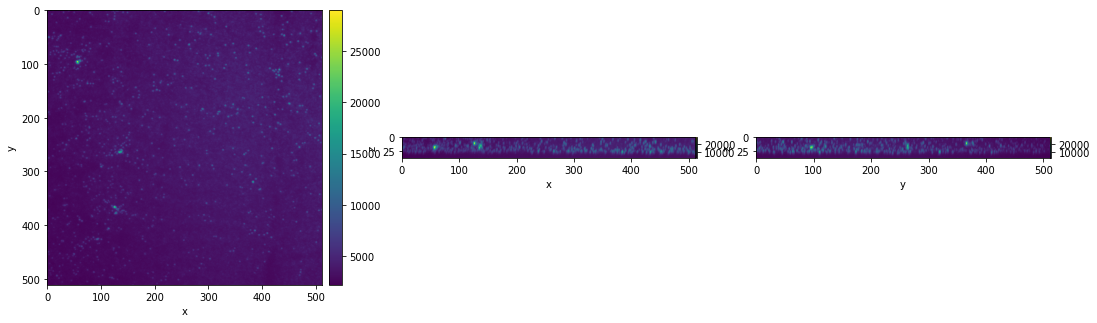

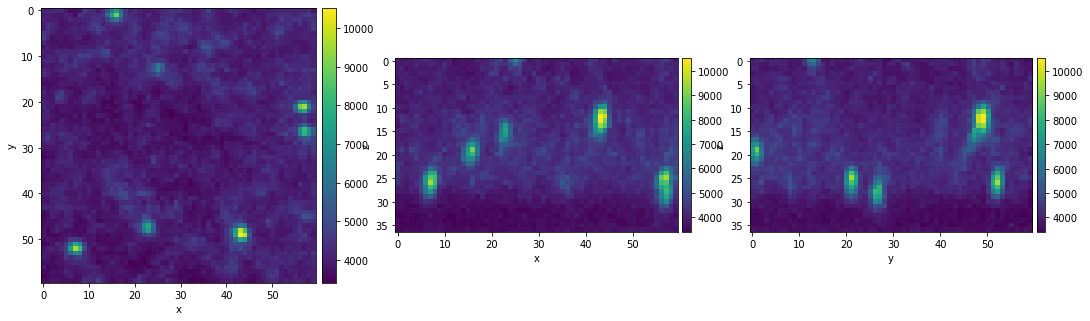

/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/smFISH_data_Titlow/rab11_smFISH_1.tif
torch.Size([43, 512, 512])


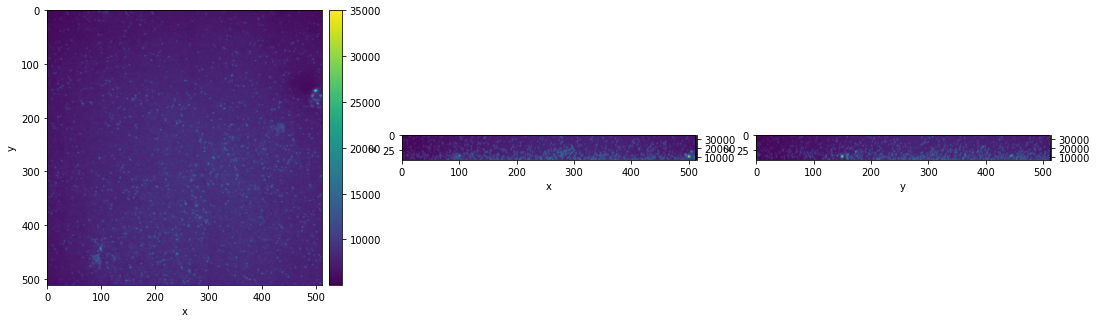

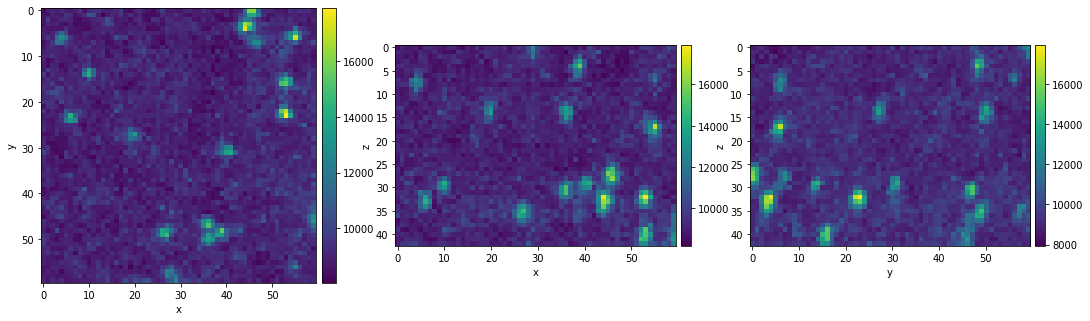

/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/smFISH_data_Titlow/rab11_smFISH_2.tif
torch.Size([24, 512, 512])


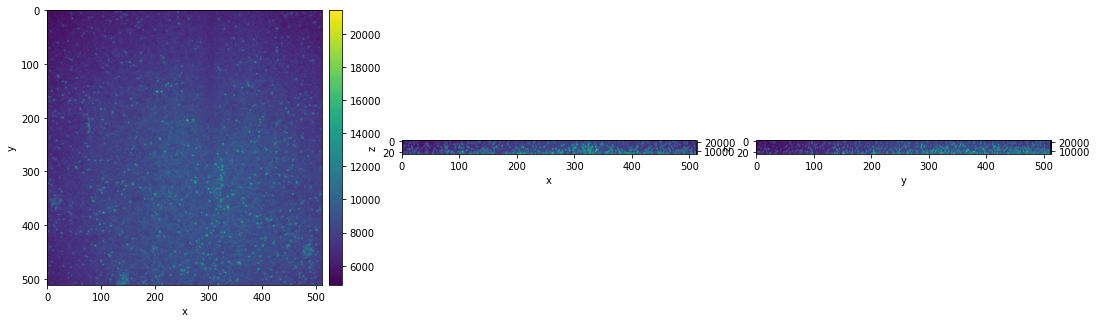

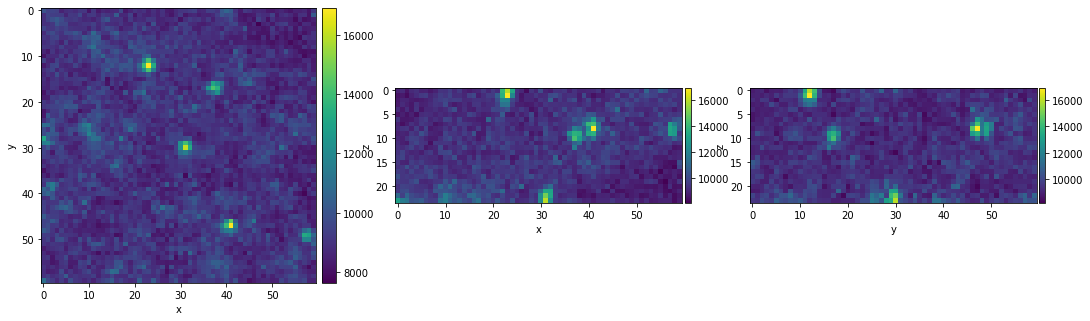

/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/smFISH_data_Titlow/rab11_smFISH_3.tif
torch.Size([45, 512, 512])


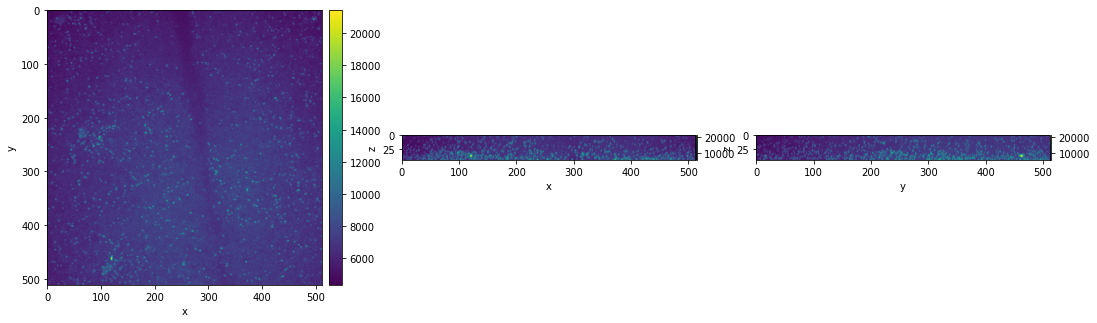

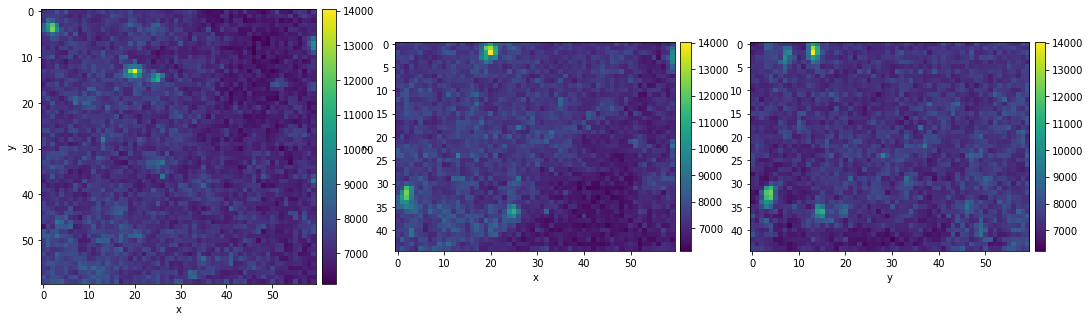

/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/smFISH_data_Titlow/rab11_smFISH_4.tif
torch.Size([36, 512, 512])


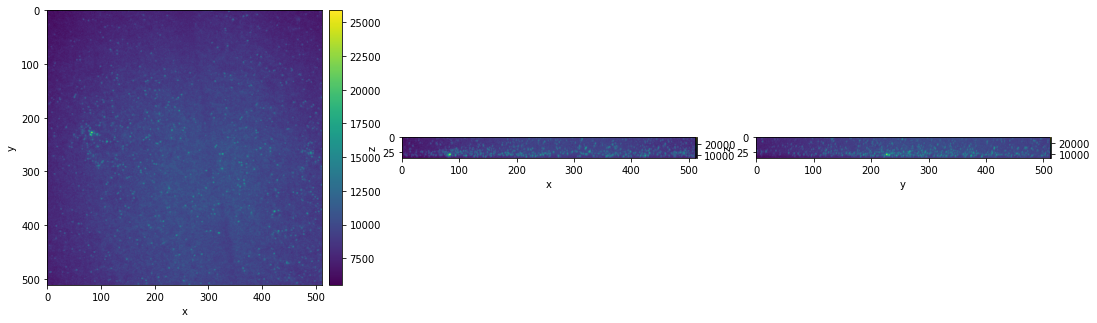

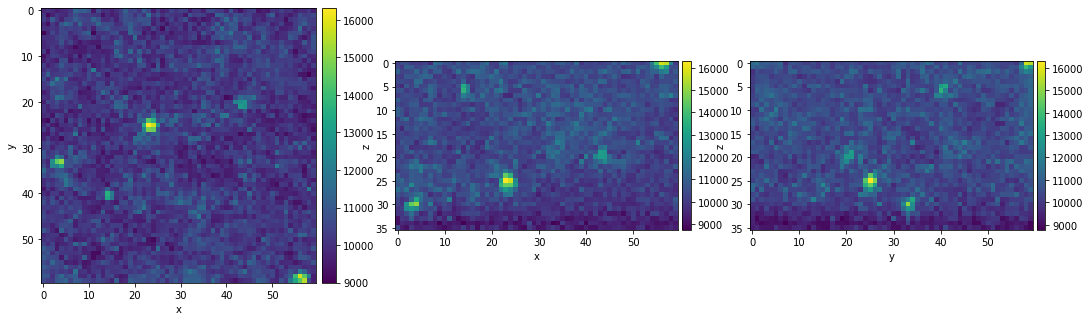

/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/smFISH_data_Titlow/scrib_smFISH_1.tif
torch.Size([512, 512])
/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/smFISH_data_Titlow/scrib_smFISH_2.tif
torch.Size([39, 512, 512])


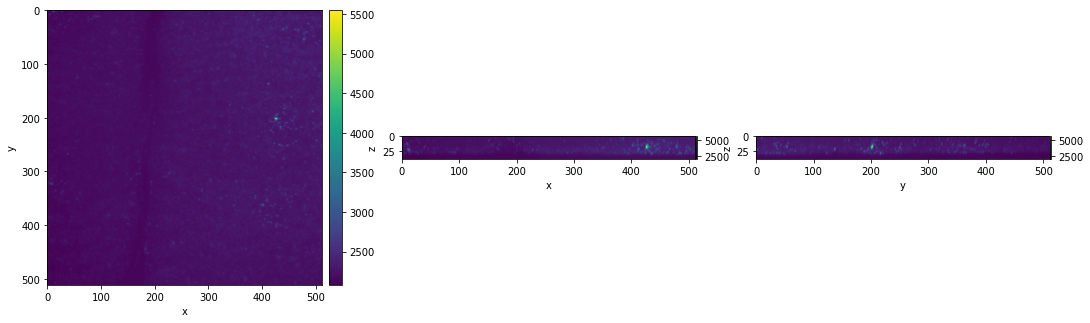

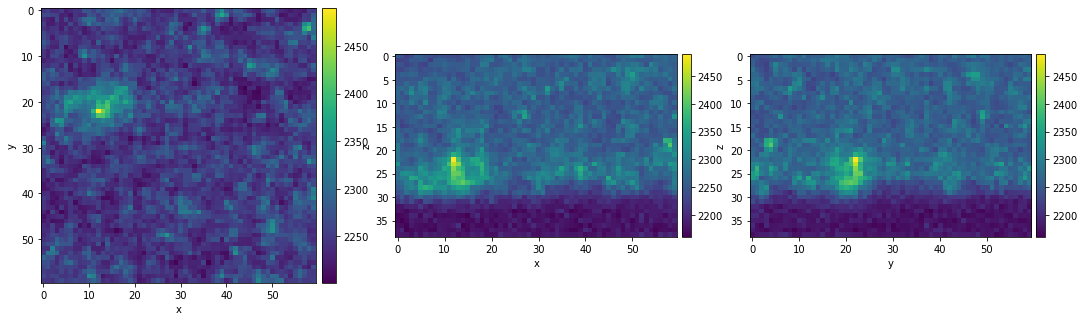

/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/smFISH_data_Titlow/scrib_smFISH_3.tif
torch.Size([35, 512, 512])


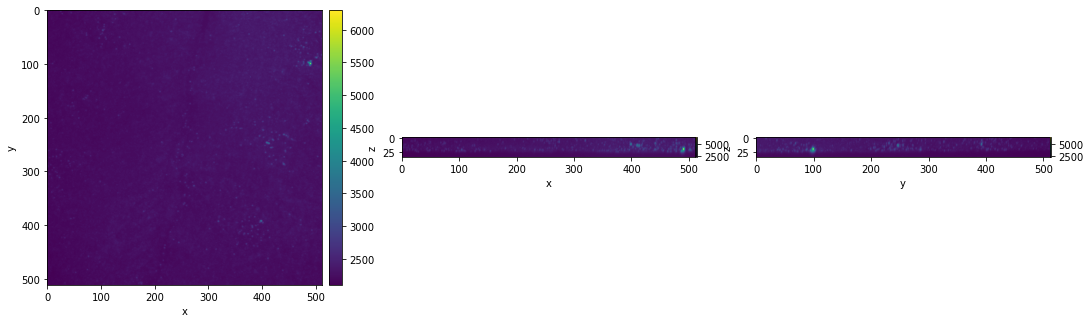

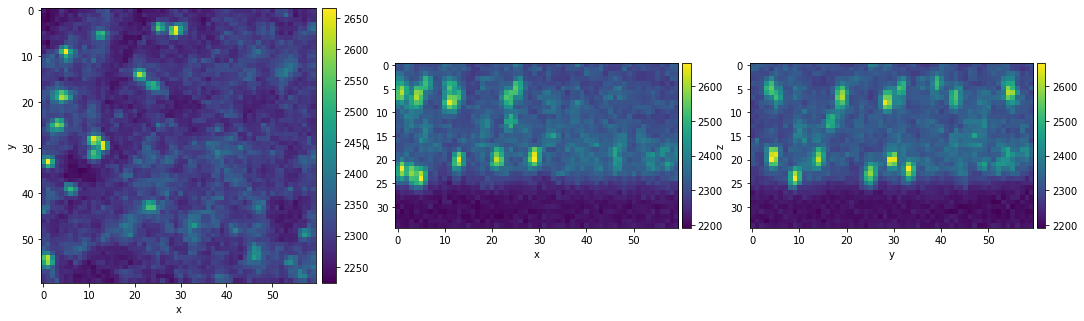

/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/smFISH_data_Titlow/scrib_smFISH_4.tif
torch.Size([46, 512, 512])


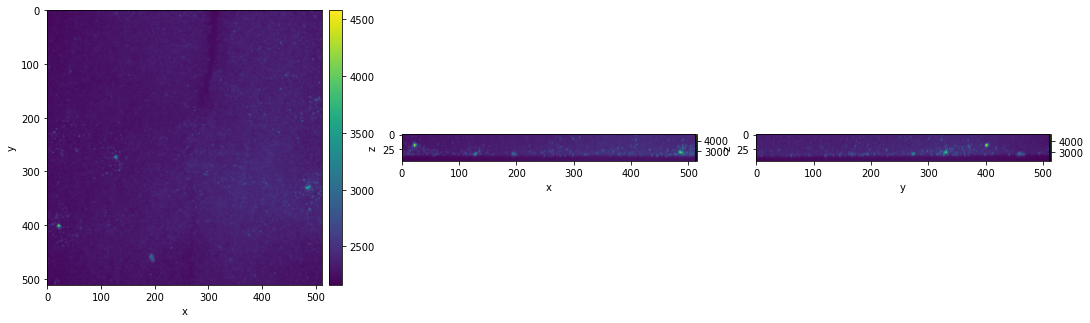

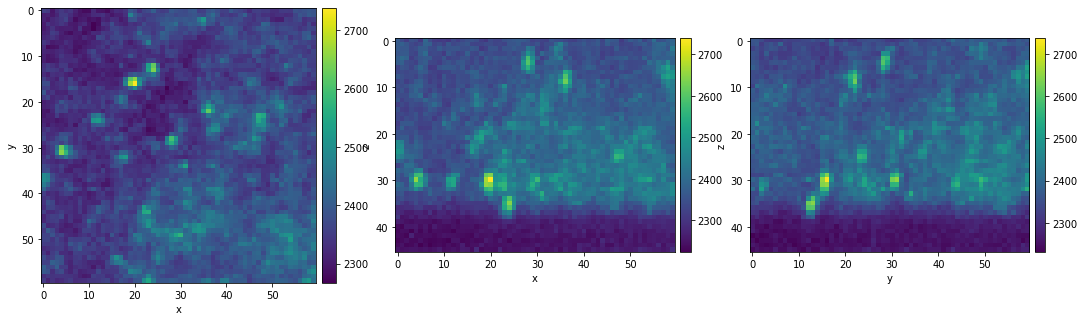

/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/smFISH_data_Titlow/sgg_smFISH_1.tif
torch.Size([28, 512, 512])


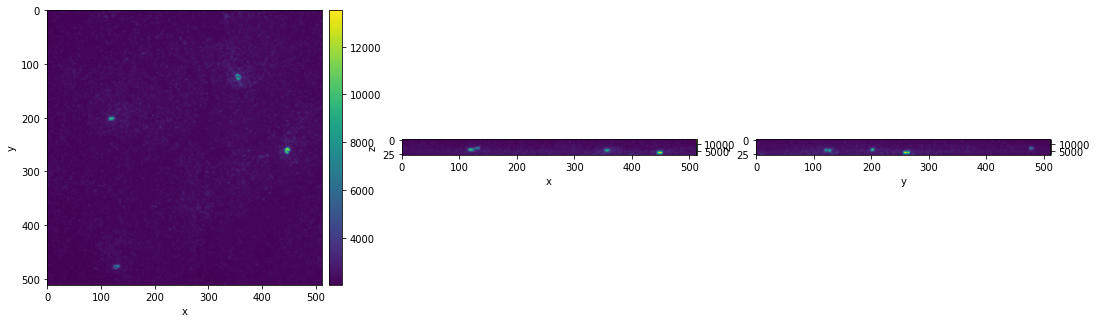

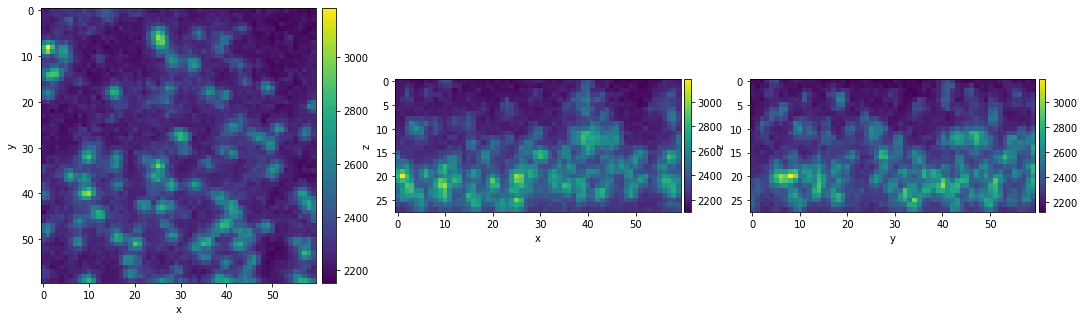

/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/smFISH_data_Titlow/sgg_smFISH_2.tif
torch.Size([27, 512, 512])


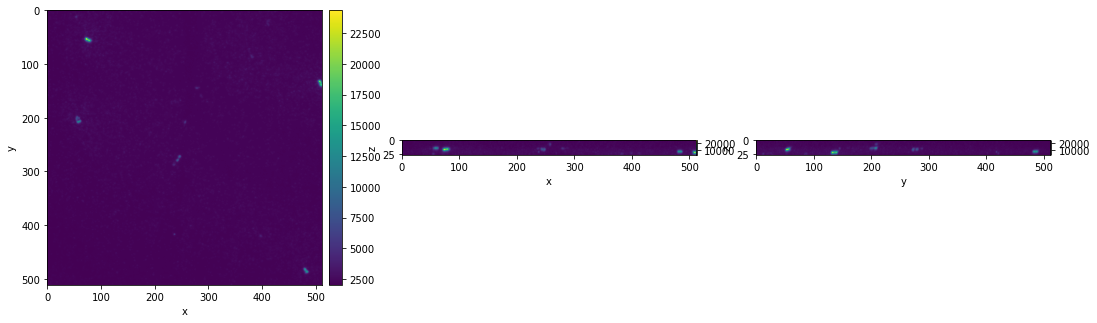

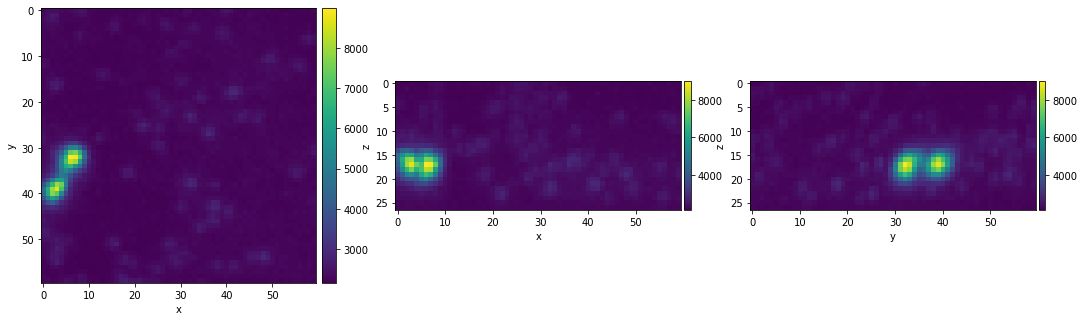

/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/smFISH_data_Titlow/sgg_smFISH_3.tif
torch.Size([27, 512, 512])


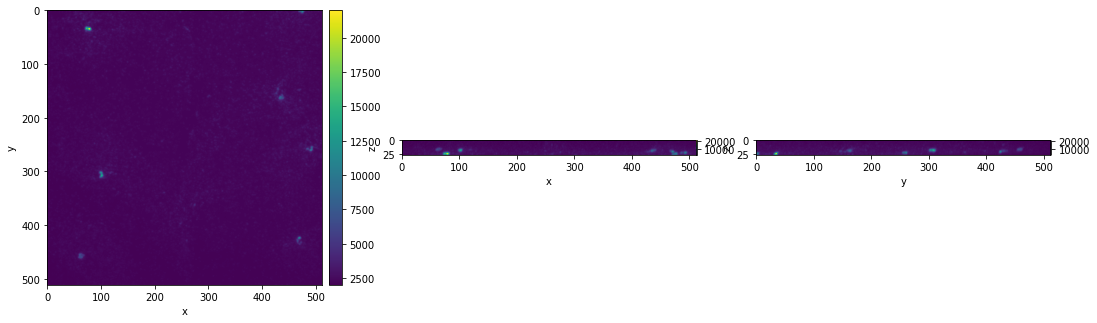

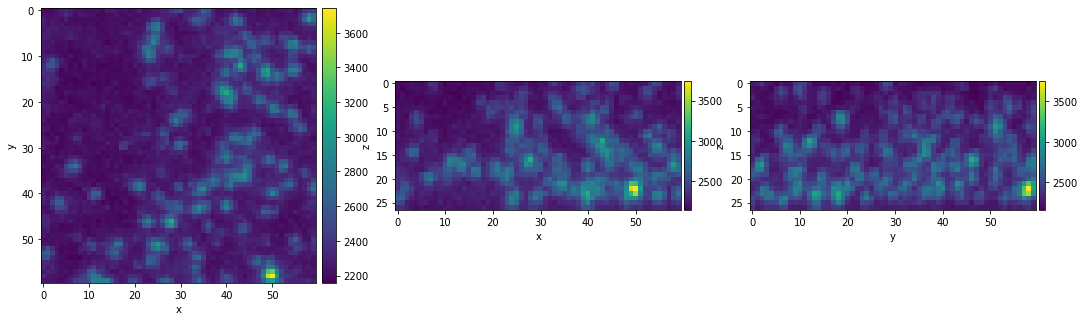

/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/smFISH_data_Titlow/sgg_smFISH_4.tif
torch.Size([25, 512, 512])


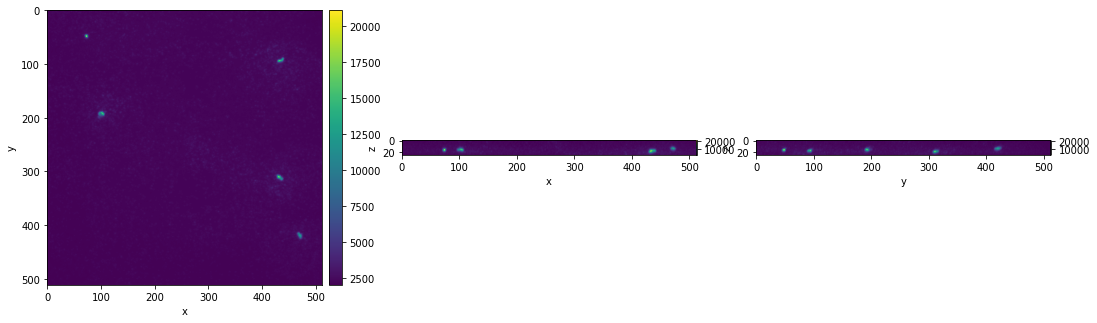

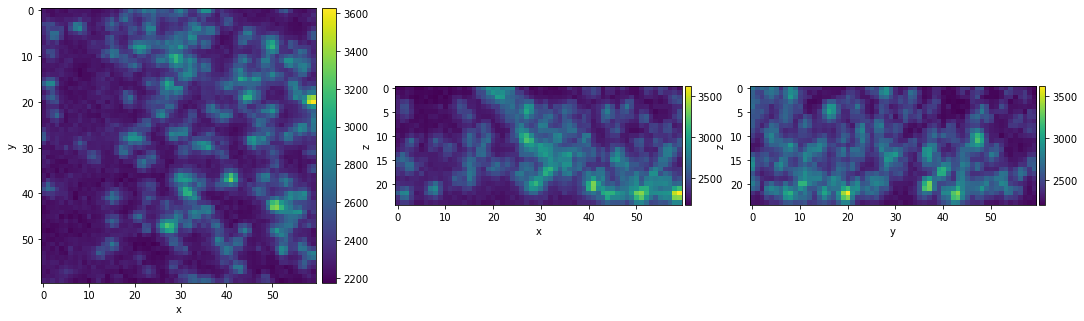

In [8]:
for f in sorted(files): 
    print(f)
    img = load_tiff_image(f)
    if img.ndim >2:
        plot_3d_projections(img[0],'max')
        plt.show()
    
        plot_3d_projections(img[0,:,240:300,240:300], 'max')
        plt.show()        